# Optimal buffer zone width
To limit gravity edge effects, many inversions use a buffer zone to extend the model beyond the extent of the gravity data. This limits the edge effects to the portion of the model outside the area of interest. A large buffer zone results is smaller errors in the area of interest, but the larger model can lead to significantly slower runtime of the code. Here we show a method to choose the optimal buffer zone width to both limit edge effects, but not significantly slow down the inversion.

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging

from polartoolkit import utils as polar_utils

from invert4geom import optimization, synthetic

# set up logging to see what's going on
logging.basicConfig(level=logging.INFO)

## Get a synthetic model
Here we will load synthetic topography data and calculate gravity for at each gridcell with no buffer zone. This will result in a noticable gravity edge effect, where there is a decay of observed gravity values towards the edges of the model. 

INFO:invert4geom:RMSE at the constraints between the starting and true topography: 19.262348539866753 m
INFO:invert4geom:Standard deviation used for noise: [0.2]


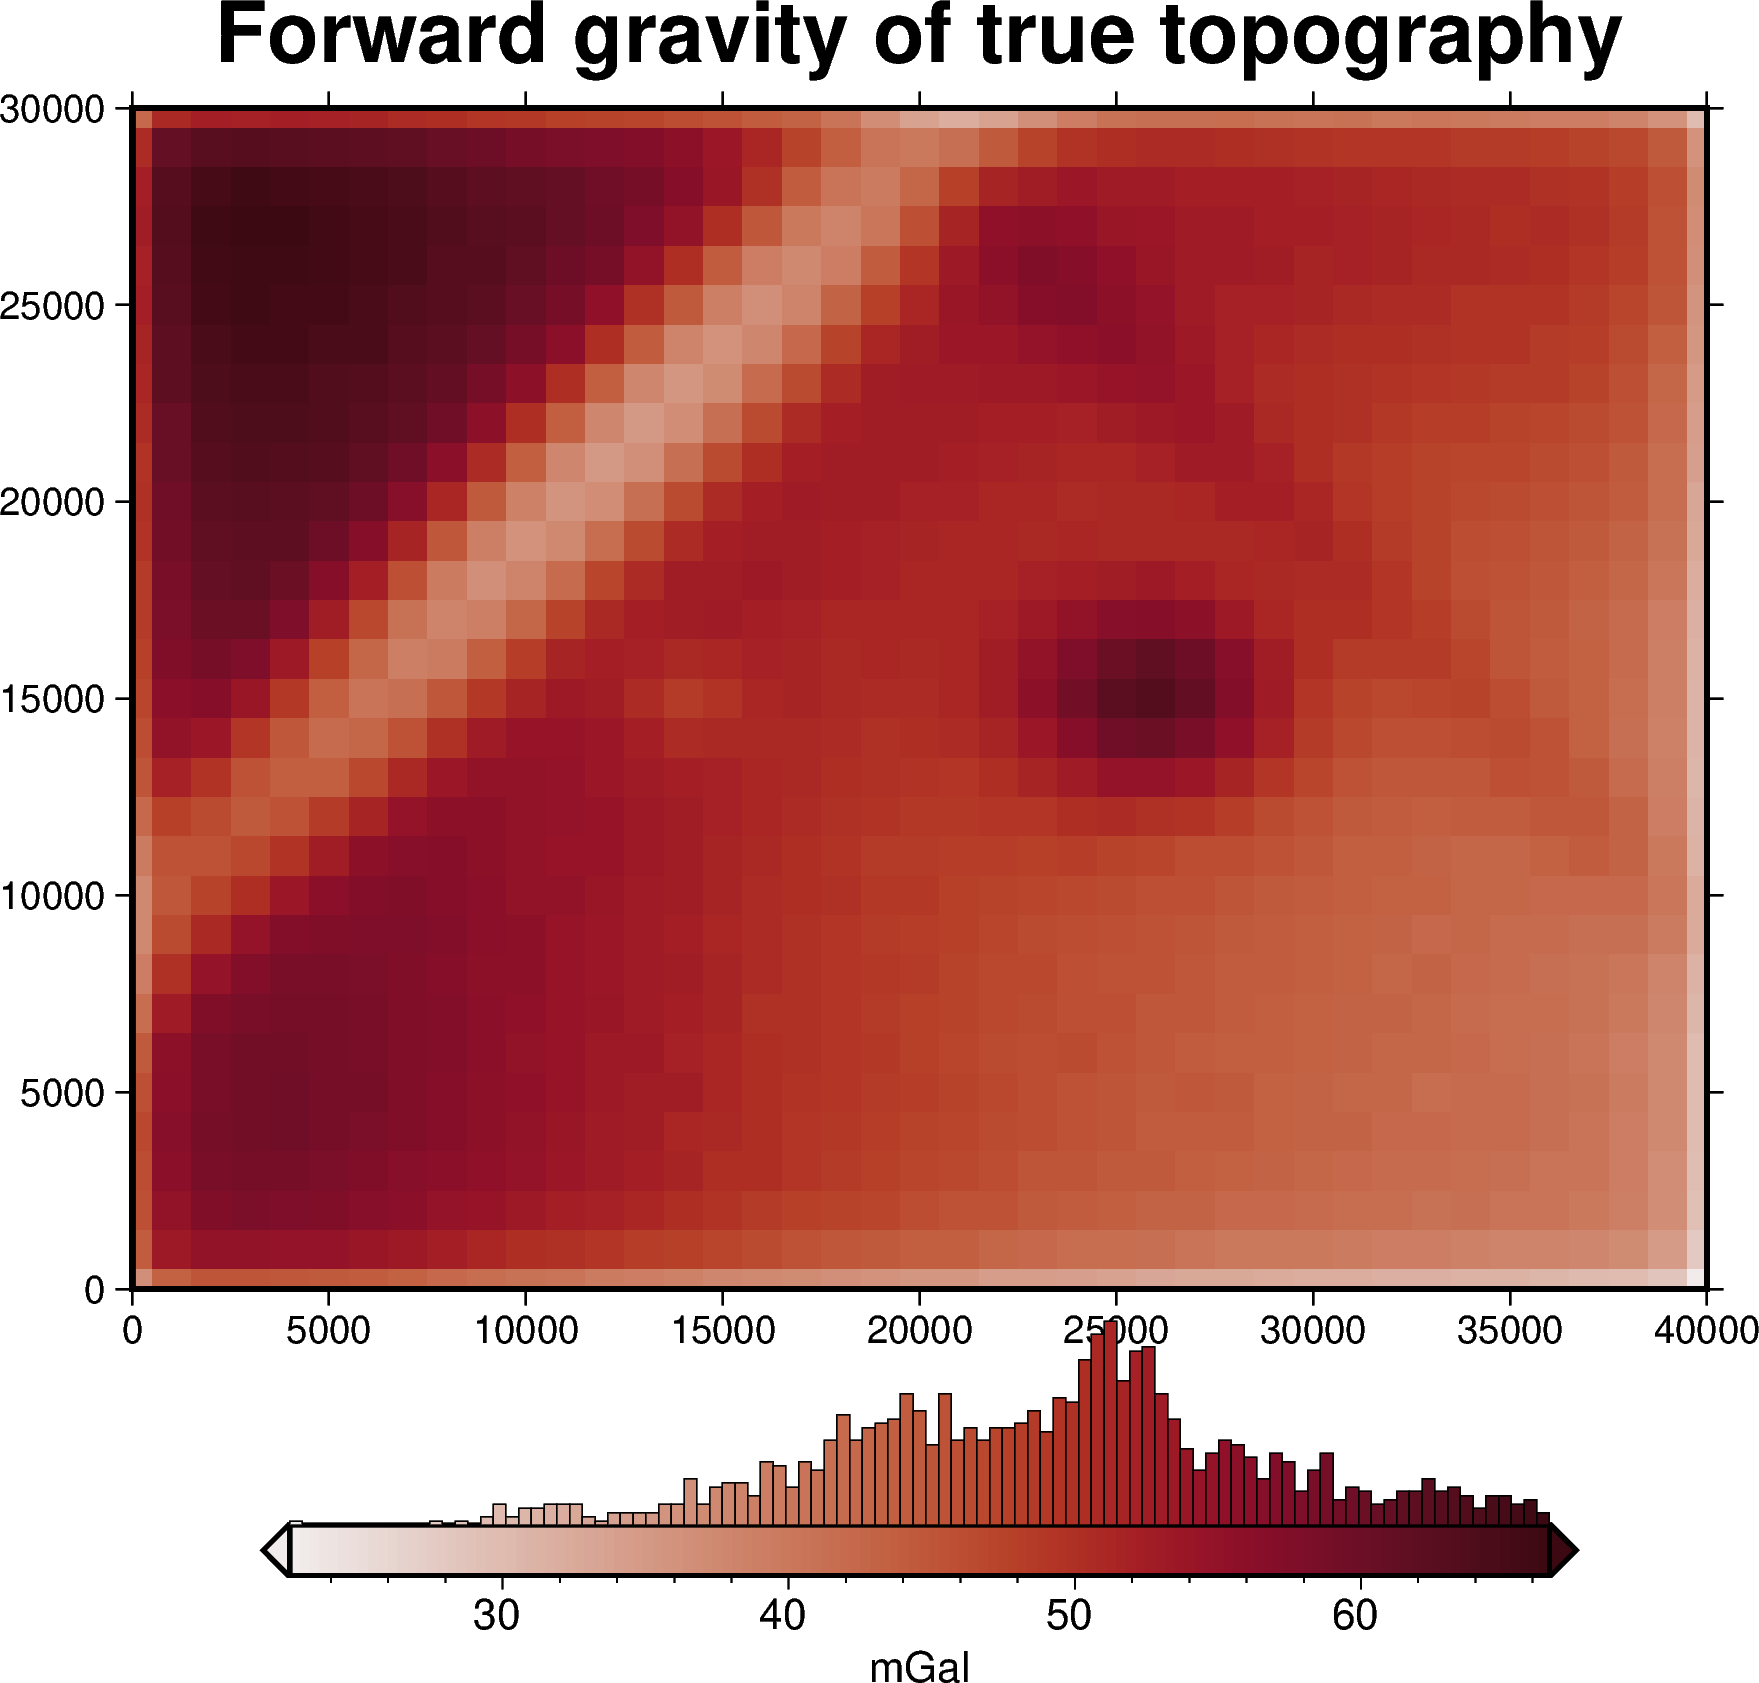

In [2]:
spacing = 1000
region = (0, 40000, 0, 30000)
zref = 0
density_contrast = 2670
gravity_obs_height = 1e3

results = synthetic.load_synthetic_model(
    spacing=spacing,
    region=region,
    number_of_constraints=10,
    zref=zref,
    density_contrast=density_contrast,
    buffer=0,
    plot_topography_diff=False,
)
starting_topography = results[1]
no_buffer_grav = results[3]

## Find optimal buffer zone width
We can run an optimization on a range of buffer zone widths and find the value which gets us closest to set amount of gravitational decay. This set amount of decay is chosen with `target`. High values will result in a small buffer zone (inversions will run faster), but will include noticable edge effects at the model edge. Conversely, small values will results in large buffer zones (slowing down the code), but will limit edge effects. Here we use a target of 3% decay. The optimization will test 20 values of buffer zone widths between 1% and 100% of the region width.

Do estimate the gravity decay, we create a flat layer of prisms and calculate it's forward gravity. The max value is then compared to the edge values to determine the amount of decay. Use the parameters `inner_region`, `spacing`, `top`, `zref` and `density` to mimic your inversion model as closely as possible.

  0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:Current trial (#8, {'buffer_perc': 5.11490095803704}) has a worse score (10.319912856412802) than either of the lower (2.498331384218871) or upper (2.709238571141506) parameter value limits, it might be best to stop the study and expand the limits.
INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 7
INFO:invert4geom:	parameter: {'buffer_perc': 18.08787364984556}
INFO:invert4geom:	scores: [0.23926445995370527]


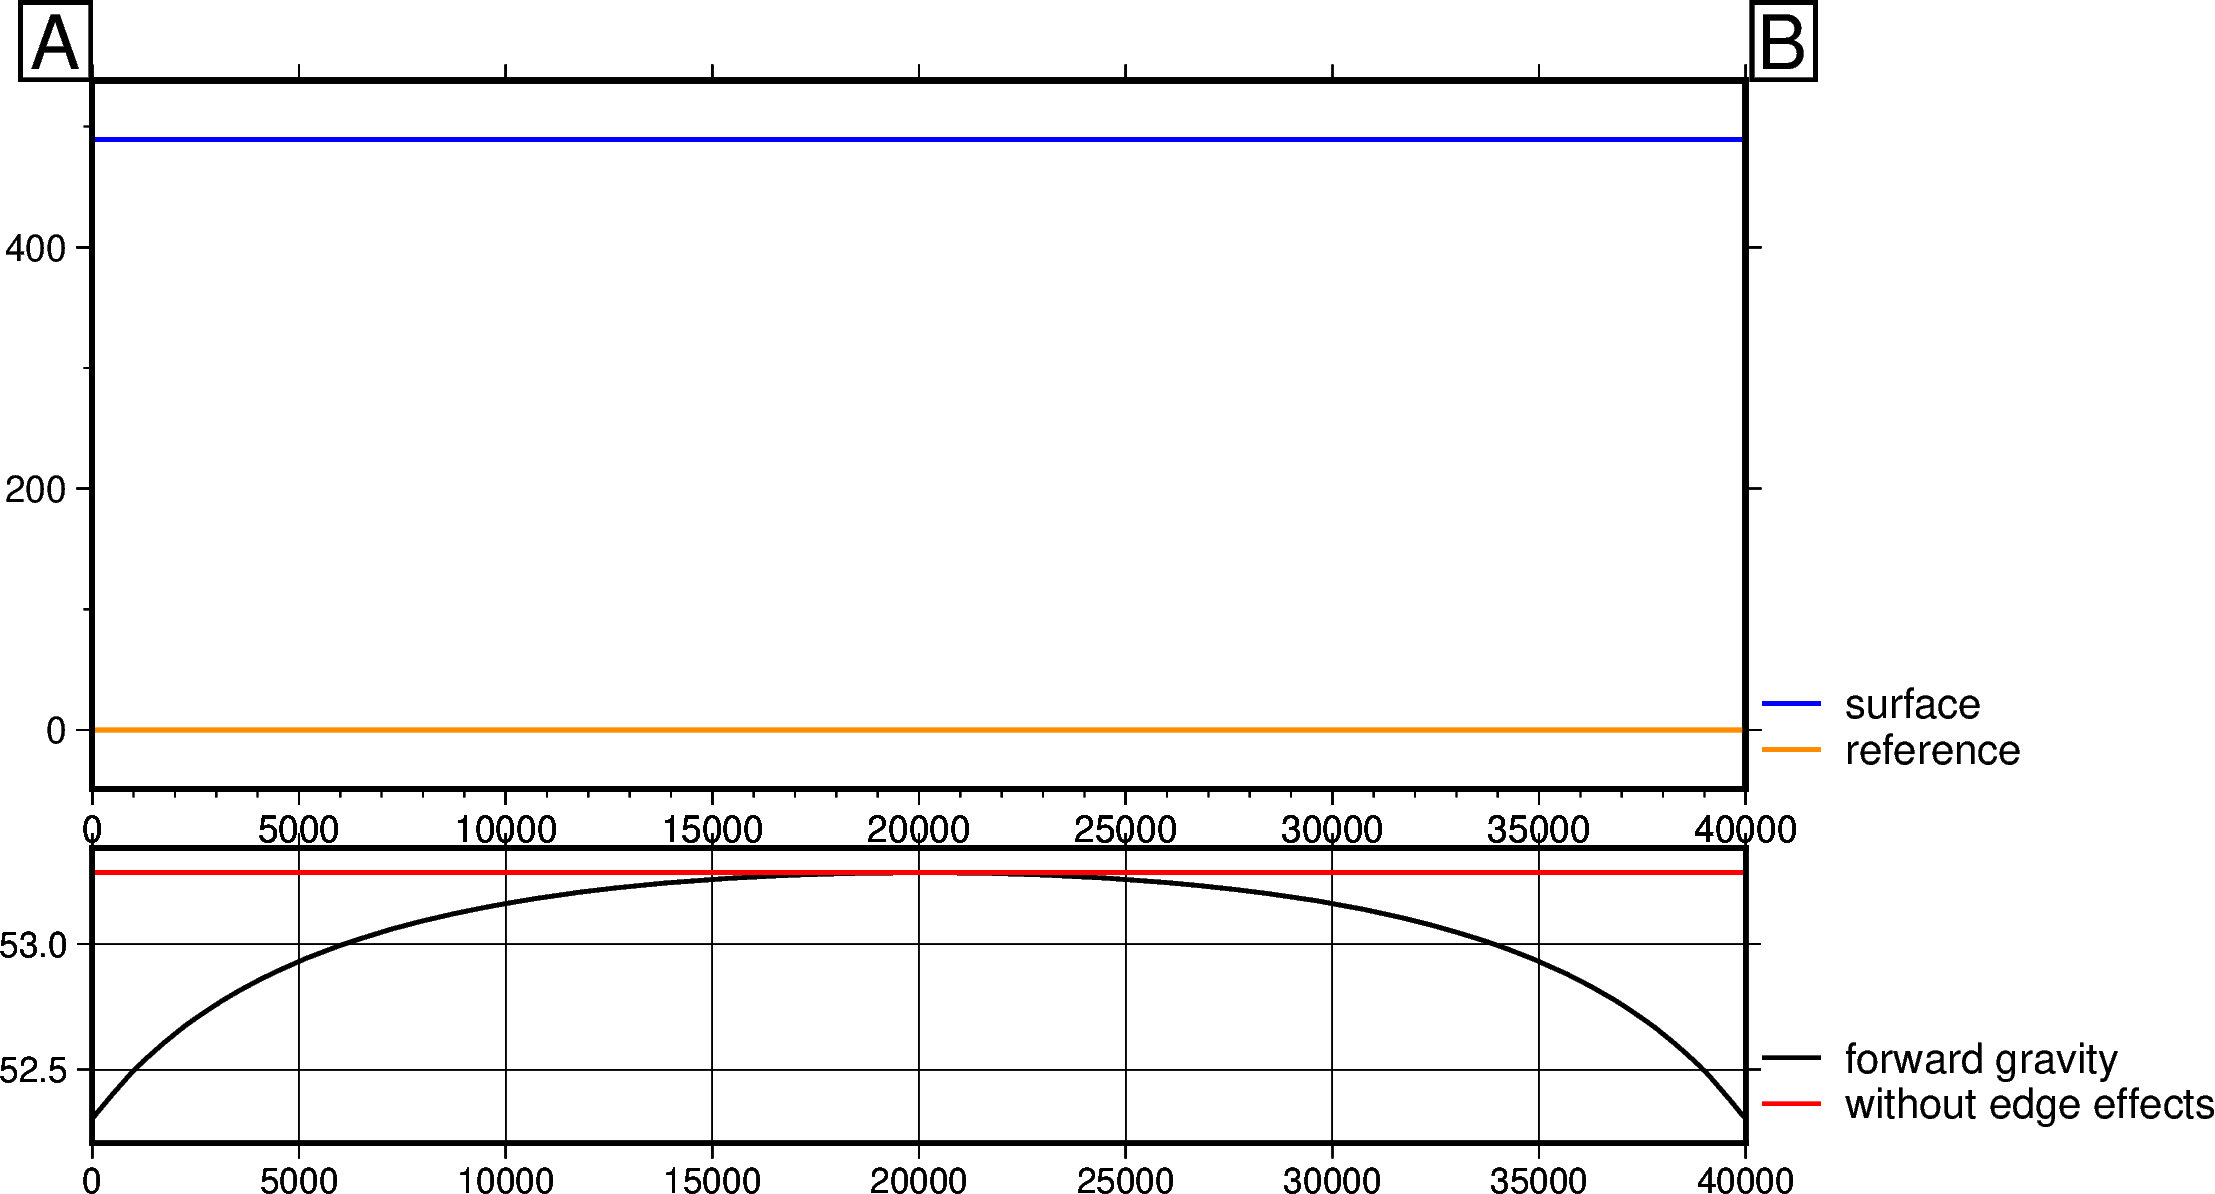

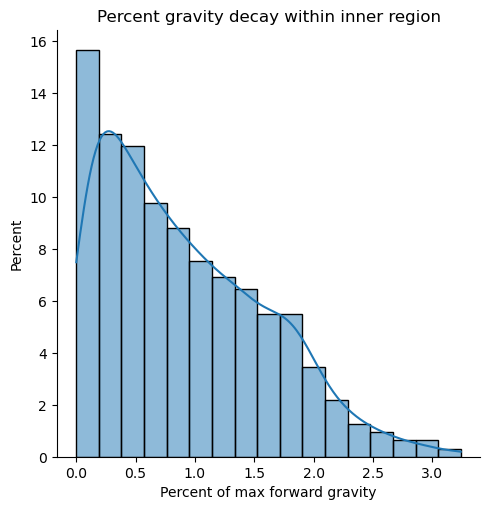

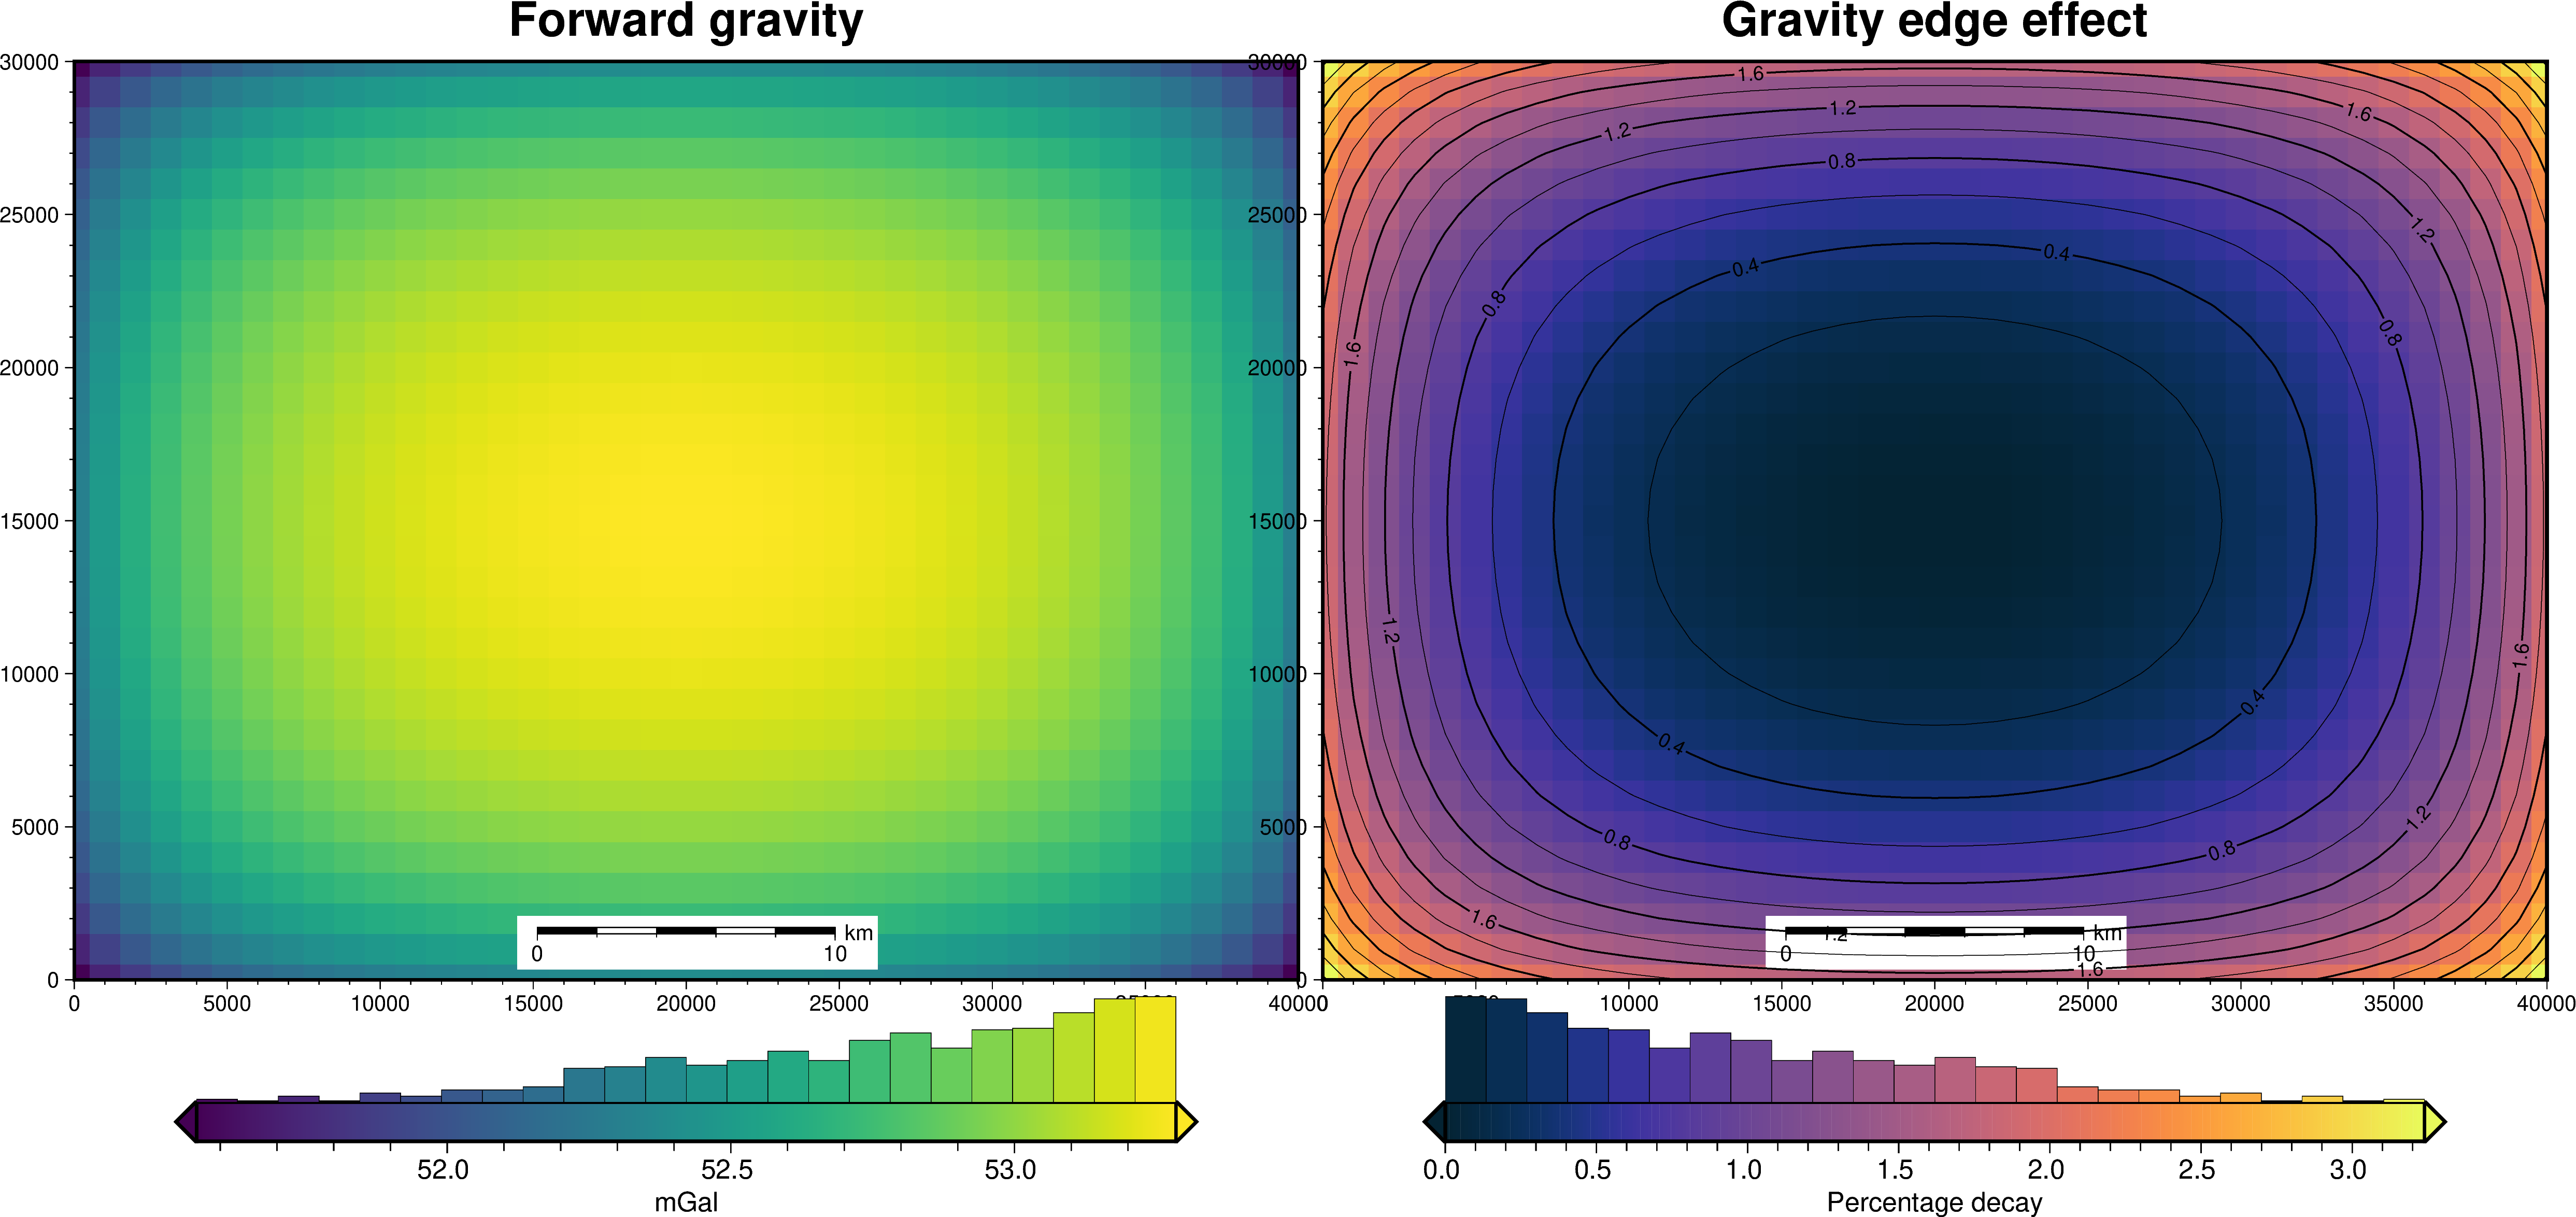

Optimal buffer width: 7000


In [3]:
study, results = optimization.optimal_buffer(
    target=3,
    buffer_perc_limits=[1, 100],
    n_trials=20,
    obs_height=gravity_obs_height,
    top=starting_topography.values.mean(),
    zref=zref,
    spacing=spacing,
    inner_region=region,
    density=density_contrast,
)
_, buffer_width, _, _ = results
print(f"Optimal buffer width: {buffer_width}")

## Use the optimal buffer width

INFO:invert4geom:RMSE at the constraints between the starting and true topography: 19.267205607288457 m
INFO:invert4geom:Standard deviation used for noise: [0.2]


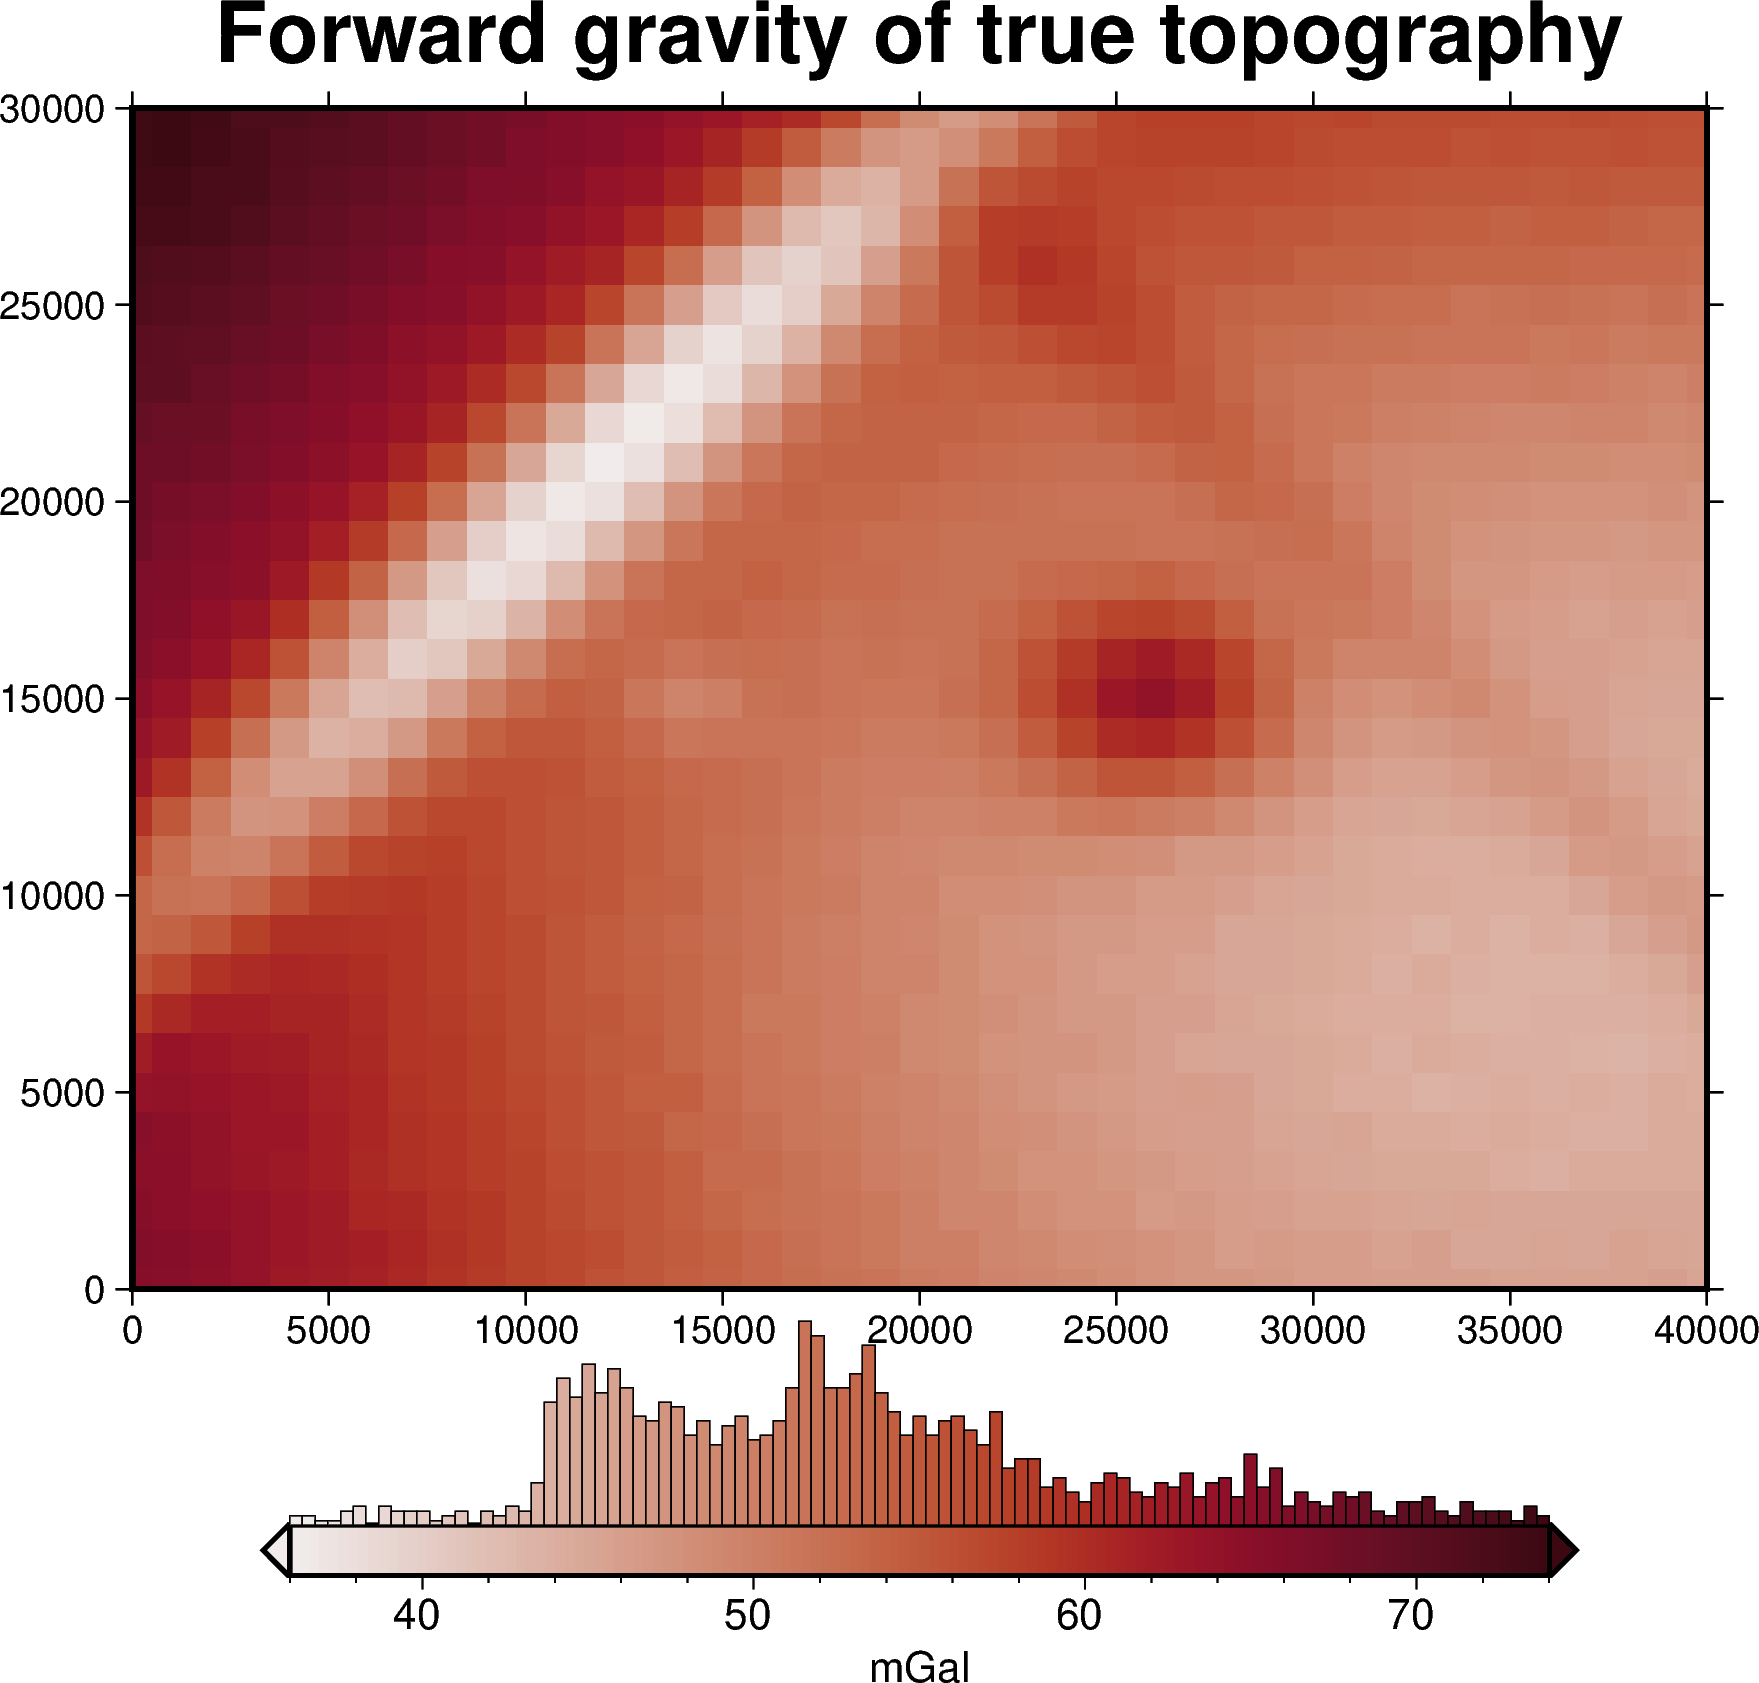

In [4]:
results = synthetic.load_synthetic_model(
    spacing=spacing,
    region=region,
    buffer=buffer_width,
    number_of_constraints=10,
    zref=zref,
    density_contrast=density_contrast,
    plot_topography_diff=False,
)

buffer_grav = results[3]

## Compare with and without buffer

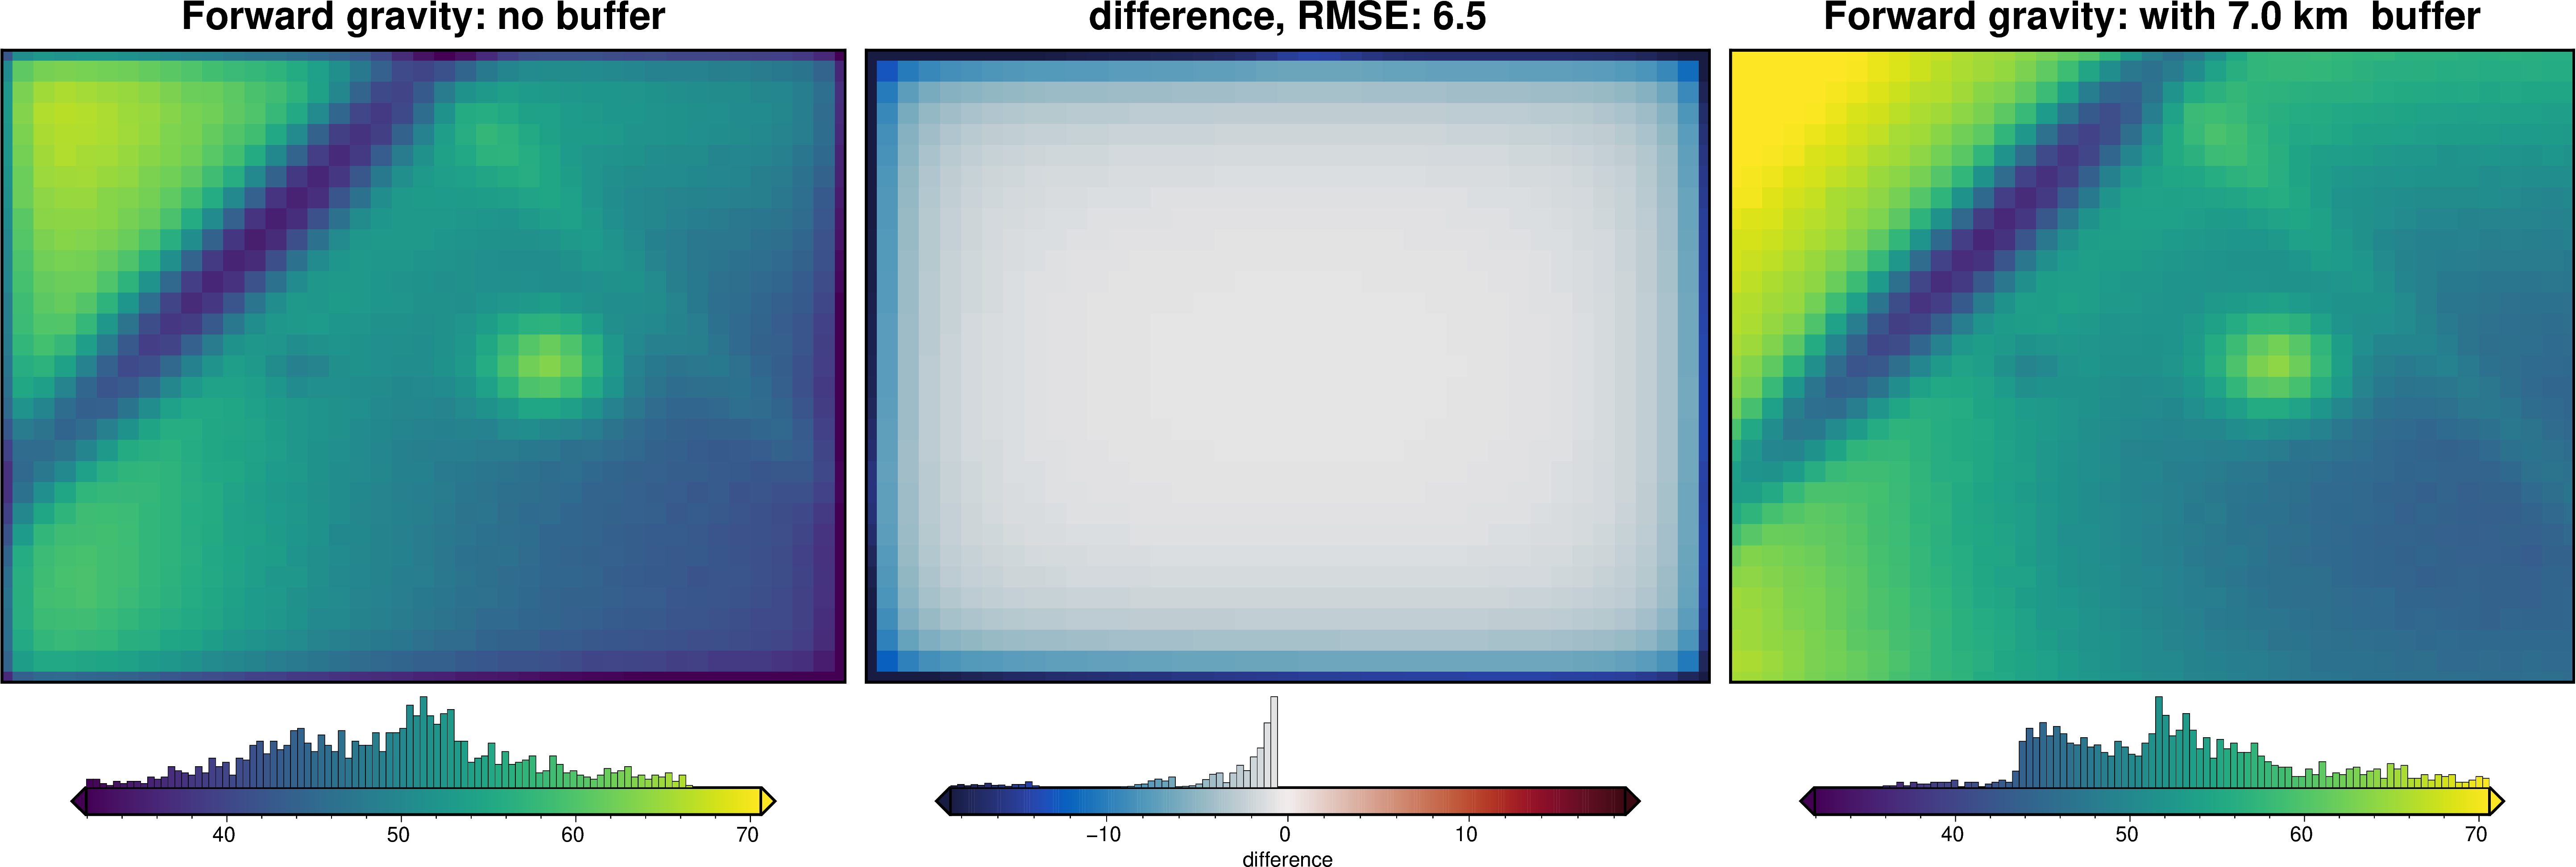

In [5]:
no_buffer_grav_grid = (
    no_buffer_grav.set_index(["northing", "easting"]).to_xarray().gravity_anomaly
)
buffer_grav_grid = (
    buffer_grav.set_index(["northing", "easting"]).to_xarray().gravity_anomaly
)

_ = polar_utils.grd_compare(
    no_buffer_grav_grid,
    buffer_grav_grid,
    plot=True,
    grid1_name="Forward gravity: no buffer",
    grid2_name=f"Forward gravity: with {buffer_width/1e3} km  buffer",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
)